# SPECFEM2D Simulation Analysis Tool

This notebook provides tools for analyzing SPECFEM2D seismic simulation results, including:
- Visualization of seismic velocity models
- Display of source-receiver configuration
- Analysis of synthetic seismograms
- Computation and visualization of adjoint sources
- Display of sensitivity kernels
- Extraction of simulation parameters and mesh resolution metrics

By: Claude on March 9, 2025

In [59]:
# Import required libraries
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import FunctionsPlotBin
from UtilityFunctions import read_trace, save_trace, grid
from scipy.integrate import simpson
import re
from IPython.display import HTML, display

# Set plotting parameters
matplotlib.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [12, 8]

In [60]:
# Add write_fortran function to FunctionsPlotBin module if it doesn't exist
if not hasattr(FunctionsPlotBin, 'write_fortran'):
    def write_fortran(filename, v):
        """Write a numpy array to a Fortran-style binary file."""
        n = np.array([v.size], dtype='int32')
        
        with open(filename, 'wb') as f:
            n.tofile(f)
            v.astype('float32').tofile(f)
            n.tofile(f)
            
    # Add to the module
    FunctionsPlotBin.write_fortran = write_fortran
    print("Added write_fortran function to FunctionsPlotBin module")

# Set paths to model directories
# Check if work directory exists first
work_dir = os.path.join(os.getcwd(), "work")
if not os.path.exists(work_dir):
    print(f"Work directory not found at: {work_dir}")
    print("Please run one of the other notebooks (like D_Specfem2D_Kernel.ipynb) first to generate simulation results.")
    print("Attempting to use example data instead...")
    
    # Try to use the example data instead
    BASE_DIR = os.path.join(os.getcwd(), "Examples")
    
    # Check if there's any output data in the examples
    example_output = os.path.join(BASE_DIR, "OUTPUT_FILES_Example01")
    if os.path.exists(example_output):
        MODEL_TRUE_DIR = example_output
        MODEL_INIT_DIR = example_output  # Use the same for both in this case
    else:
        # Just point to the example directory structure
        MODEL_TRUE_DIR = BASE_DIR
        MODEL_INIT_DIR = BASE_DIR
    
    MODEL_ADJ_DIR = None
    DATA_DIR = os.path.join(BASE_DIR, "DATA_Example01")
    
else:
    # Try the MultiReceiver directory specifically since we can see it from errors
    multi_receiver_dir = os.path.join(work_dir, "ExampleKernelMultiReceiver")
    if os.path.exists(multi_receiver_dir):
        BASE_DIR = multi_receiver_dir
        MODEL_TRUE_DIR = os.path.join(BASE_DIR, "OUTPUT_FILES_TRUE") if os.path.exists(os.path.join(BASE_DIR, "OUTPUT_FILES_TRUE")) else None
        MODEL_INIT_DIR = os.path.join(BASE_DIR, "OUTPUT_FILES_INIT") if os.path.exists(os.path.join(BASE_DIR, "OUTPUT_FILES_INIT")) else None
        MODEL_ADJ_DIR = os.path.join(BASE_DIR, "OUTPUT_FILES_ADJ") if os.path.exists(os.path.join(BASE_DIR, "OUTPUT_FILES_ADJ")) else None
        DATA_DIR = os.path.join(BASE_DIR, "DATA")
    else:
        # Try to find any kernel directories in work directory
        kernel_dirs = [d for d in os.listdir(work_dir) if d.startswith("ExampleKernel")]
        
        if kernel_dirs:
            # Use the first kernel directory found
            kernel_dir = kernel_dirs[0]
            BASE_DIR = os.path.join(work_dir, kernel_dir)
            
            # Check for output directories
            MODEL_TRUE_DIR = os.path.join(BASE_DIR, "OUTPUT_FILES_TRUE") if os.path.exists(os.path.join(BASE_DIR, "OUTPUT_FILES_TRUE")) else None
            MODEL_INIT_DIR = os.path.join(BASE_DIR, "OUTPUT_FILES_INIT") if os.path.exists(os.path.join(BASE_DIR, "OUTPUT_FILES_INIT")) else None
            MODEL_ADJ_DIR = os.path.join(BASE_DIR, "OUTPUT_FILES_ADJ") if os.path.exists(os.path.join(BASE_DIR, "OUTPUT_FILES_ADJ")) else None
            DATA_DIR = os.path.join(BASE_DIR, "DATA")
        else:
            print("No kernel simulation directories found in work directory.")
            # Try to fall back to Examples directory
            BASE_DIR = os.path.join(os.getcwd(), "Examples")
            MODEL_TRUE_DIR = os.path.join(BASE_DIR, "OUTPUT_FILES_Example01") if os.path.exists(os.path.join(BASE_DIR, "OUTPUT_FILES_Example01")) else None
            MODEL_INIT_DIR = MODEL_TRUE_DIR  # Use the same directory for initial model in this case
            MODEL_ADJ_DIR = None
            DATA_DIR = os.path.join(BASE_DIR, "DATA_Example01")

# Verify paths and print status
print("Directories configured:")
print(f"Base directory: {BASE_DIR}")

if MODEL_TRUE_DIR and os.path.exists(MODEL_TRUE_DIR):
    print(f"True model: {MODEL_TRUE_DIR} ✓")
else:
    print(f"True model: {MODEL_TRUE_DIR or 'Not found'} ✗")
    MODEL_TRUE_DIR = None

if MODEL_INIT_DIR and os.path.exists(MODEL_INIT_DIR):
    print(f"Initial model: {MODEL_INIT_DIR} ✓") 
else:
    print(f"Initial model: {MODEL_INIT_DIR or 'Not found'} ✗")
    MODEL_INIT_DIR = None
    
if MODEL_ADJ_DIR and os.path.exists(MODEL_ADJ_DIR):
    print(f"Adjoint results: {MODEL_ADJ_DIR} ✓")
else:
    print(f"Adjoint results: {MODEL_ADJ_DIR or 'Not found'} ✗")
    MODEL_ADJ_DIR = None

if DATA_DIR and os.path.exists(DATA_DIR):
    print(f"Data directory: {DATA_DIR} ✓")
else:
    print(f"Data directory: {DATA_DIR or 'Not found'} ✗")
    DATA_DIR = None

if not (MODEL_TRUE_DIR or MODEL_INIT_DIR or DATA_DIR):
    print("\nWARNING: No valid data directories found. Please run a SPECFEM2D simulation first.")
    print("You can use one of the other notebooks (e.g., D_Specfem2D_Kernel.ipynb) to generate simulation data.")

Directories configured:
Base directory: /home/masa/FWI_MAH575/JupyterNotebooks/work/ExampleKernelMultiReceiver
True model: /home/masa/FWI_MAH575/JupyterNotebooks/work/ExampleKernelMultiReceiver/OUTPUT_FILES_TRUE ✓
Initial model: Not found ✗
Adjoint results: Not found ✗
Data directory: /home/masa/FWI_MAH575/JupyterNotebooks/work/ExampleKernelMultiReceiver/DATA ✓


In [62]:
# Create a function to generate an initial model by perturbing the true model
def create_perturbed_model(true_model_dir, output_dir, perturbation_percent=5):
    """
    Creates a perturbed velocity model by modifying the true model by the specified percentage.
    
    Args:
        true_model_dir: Directory containing the true model binary files
        output_dir: Directory to save the perturbed model files
        perturbation_percent: Percentage to modify velocities (+ or - value)
    
    Returns:
        Boolean indicating success or failure
    """
    if not true_model_dir or not os.path.exists(true_model_dir):
        print(f"True model directory not found: {true_model_dir}")
        return False
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # List of files to copy directly (without modification)
    files_to_copy = [
        "proc000000_x.bin", "proc000000_z.bin", "proc000000_NSPEC_ibool.bin",
        "proc000000_jacobian.bin", "proc000000_rho.bin", 
        "Database00000.bin"
    ]
    
    # Files to modify (velocity models)
    files_to_modify = [
        "proc000000_vp.bin", "proc000000_vs.bin"
    ]
    
    # Copy files without modification
    for filename in files_to_copy:
        source_file = os.path.join(true_model_dir, filename)
        dest_file = os.path.join(output_dir, filename)
        
        if os.path.exists(source_file):
            shutil.copy2(source_file, dest_file)
            print(f"Copied: {filename}")
        else:
            print(f"Warning: {filename} not found in true model directory")
    
    # Modify velocity files
    for filename in files_to_modify:
        source_file = os.path.join(true_model_dir, filename)
        dest_file = os.path.join(output_dir, filename)
        
        if os.path.exists(source_file):
            try:
                # Read the true model velocity
                true_velocity = FunctionsPlotBin.read_fortran(source_file)
                
                # Apply perturbation (decrease by specified percentage)
                perturbation_factor = 1.0 - (perturbation_percent / 100.0)
                perturbed_velocity = true_velocity * perturbation_factor
                
                # Write the perturbed model
                FunctionsPlotBin.write_fortran(dest_file, perturbed_velocity)
                print(f"Modified: {filename} (decreased by {perturbation_percent}%)")
            except Exception as e:
                print(f"Error modifying {filename}: {e}")
                return False
        else:
            print(f"Warning: {filename} not found in true model directory")
            return False
    
    # Copy seismogram files if they exist
    seismogram_files = [f for f in os.listdir(true_model_dir) if f.endswith('.semd')]
    for seismo_file in seismogram_files:
        source_file = os.path.join(true_model_dir, seismo_file)
        dest_file = os.path.join(output_dir, seismo_file)
        
        try:
            # Read the true seismogram
            true_trace = read_trace(source_file)
            
            # Apply a time shift to simulate slower velocities
            # For a 5% velocity decrease, waves arrive ~5% later
            shifted_trace = true_trace.copy()
            shifted_trace.data = np.roll(true_trace.data, int(len(true_trace.data) * perturbation_percent / 100))
            
            # Save the shifted trace
            save_trace(shifted_trace, dest_file)
            print(f"Modified seismogram: {seismo_file}")
        except Exception as e:
            print(f"Error modifying seismogram {seismo_file}: {e}")
            # Continue even if some seismograms fail

    print(f"Initial model with {perturbation_percent}% perturbation created successfully in {output_dir}")
    return True

# Create a perturbed initial model if:
# 1. True model exists
# 2. Initial model doesn't exist or we're explicitly asked to create a new one

# Create a directory for the perturbed model
if MODEL_TRUE_DIR and os.path.exists(MODEL_TRUE_DIR):
    PERTURBED_MODEL_DIR = os.path.join(BASE_DIR, "OUTPUT_FILES_PERTURBED")
    
    # Create the perturbed model
    print(f"Creating perturbed initial model with 5% lower velocities...")
    success = create_perturbed_model(MODEL_TRUE_DIR, PERTURBED_MODEL_DIR, 5)
    
    if success:
        # Use the perturbed model as the initial model
        MODEL_INIT_DIR = PERTURBED_MODEL_DIR
        print(f"Using perturbed model as initial model: {MODEL_INIT_DIR} ✓")
    else:
        print("Failed to create perturbed model, will use true model if available")
        if not MODEL_INIT_DIR and MODEL_TRUE_DIR:
            MODEL_INIT_DIR = MODEL_TRUE_DIR
            print(f"Using true model as initial model (fallback): {MODEL_INIT_DIR} ✓")

# Read and display parameter file
par_file_path = os.path.join(DATA_DIR, "Par_file") if DATA_DIR else None
parameters = read_parameter_file(par_file_path)
sim_type, wave_mode = display_parameters(parameters)

Creating perturbed initial model with 5% lower velocities...
Copied: proc000000_x.bin
Copied: proc000000_z.bin
Copied: proc000000_NSPEC_ibool.bin
Copied: proc000000_jacobian.bin
Copied: proc000000_rho.bin
Copied: Database00000.bin
Modified: proc000000_vp.bin (decreased by 5%)
Modified: proc000000_vs.bin (decreased by 5%)
Modified seismogram: AA.S0001.BXY.semd
Modified seismogram: AA.S0002.BXY.semd
Modified seismogram: AA.S0003.BXY.semd
Initial model with 5% perturbation created successfully in /home/masa/FWI_MAH575/JupyterNotebooks/work/ExampleKernelMultiReceiver/OUTPUT_FILES_PERTURBED
Using perturbed model as initial model: /home/masa/FWI_MAH575/JupyterNotebooks/work/ExampleKernelMultiReceiver/OUTPUT_FILES_PERTURBED ✓


Parameter,Value,Description
SIMULATION_TYPE,1,"1=forward, 2=adjoint, 3=both"
NSTEP,1600,Total number of time steps
DT,1.1d-3,Time step size in seconds
P_SV,.false.,P-SV (True) or SH (False) wave simulation
NSOURCES,1,Number of seismic sources
NPROC,1,Number of MPI processes
seismotype,1,"1=displacement, 2=velocity, 3=acceleration..."
xmin,0.d0,Model X minimum coordinate
xmax,4000.d0,Model X maximum coordinate
nx,80,Number of elements along X


In [63]:
def read_stations_file(file_path):
    """Read SPECFEM2D STATIONS file and extract receiver information"""
    stations = []
    
    if not file_path or not os.path.exists(file_path):
        print(f"Stations file not found: {file_path}")
        return stations
    
    with open(file_path, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        if line.strip() == '' or line.strip().startswith('#'):
            continue
            
        # Parse station information
        parts = line.split()
        if len(parts) >= 6:
            station = {
                'name': parts[0],
                'network': parts[1],
                'x': float(parts[2]),
                'z': float(parts[3]),
                'buried': float(parts[4]),
                'clock_correction': float(parts[5])
            }
            stations.append(station)
    
    return stations

# Read station information
stations_file_path = os.path.join(DATA_DIR, "STATIONS") if DATA_DIR else None
stations = read_stations_file(stations_file_path)

# Display receiver information
if stations:
    print(f"\nNumber of receivers: {len(stations)}")
    print("Receiver locations:")
    for i, station in enumerate(stations, 1):
        print(f"  {i}. {station['network']}.{station['name']}: ({station['x']}, {station['z']}) meters")
else:
    print("\nNo receiver information available")


Number of receivers: 3
Receiver locations:
  1. AA.S0001: (3000.0, 2000.0) meters
  2. AA.S0002: (2000.0, 3000.0) meters
  3. AA.S0003: (2000.0, 1000.0) meters



Plotting model comparison...


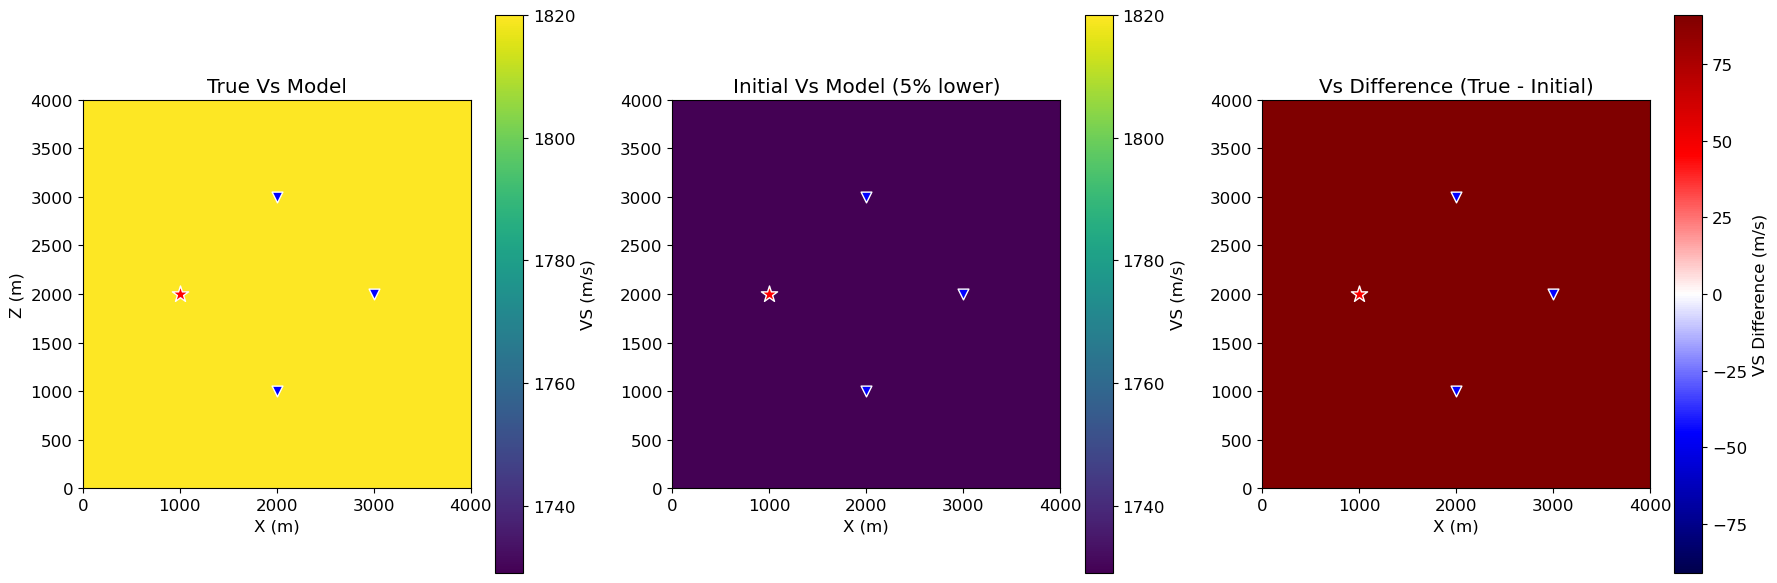

In [64]:
def plot_model(model_dir, model_type='vs', title=None, show_source=True, show_receivers=True, vmin=None, vmax=None):
    """Plot a velocity model with source and receiver locations"""
    # First check if model_dir exists
    if not model_dir or not os.path.exists(model_dir):
        print(f"Model directory not found: {model_dir}")
        return None, None
        
    x_coords_file = os.path.join(model_dir, "proc000000_x.bin")
    z_coords_file = os.path.join(model_dir, "proc000000_z.bin")
    
    if model_type.lower() == 'vs':
        model_file = os.path.join(model_dir, "proc000000_vs.bin")
        colorbar_label = "Vs (m/s)"
    elif model_type.lower() == 'vp':
        model_file = os.path.join(model_dir, "proc000000_vp.bin")
        colorbar_label = "Vp (m/s)"
    elif model_type.lower() == 'rho':
        model_file = os.path.join(model_dir, "proc000000_rho.bin")
        colorbar_label = "Density (kg/m³)"
    else:
        print(f"Unknown model type: {model_type}")
        return None, None
    
    # Check if files exist
    missing_files = []
    for file in [x_coords_file, z_coords_file, model_file]:
        if not os.path.exists(file):
            missing_files.append(file)
    
    if missing_files:
        print(f"The following files are missing:")
        for file in missing_files:
            print(f"  - {file}")
        return None, None
    
    try:
        # Load coordinate and model data
        x = FunctionsPlotBin.read_fortran(x_coords_file)
        z = FunctionsPlotBin.read_fortran(z_coords_file)
        model_data = FunctionsPlotBin.read_fortran(model_file)
        
        # Create mesh grid for plotting
        X, Z, MODEL = grid(x, z, model_data)
        
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Plot model
        im = ax.imshow(MODEL, extent=[x.min(), x.max(), z.min(), z.max()],
                      cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label(colorbar_label)
        
        # Add source
        if show_source and 'source_x' in globals() and 'source_z' in globals():
            ax.scatter(source_x, source_z, s=200, marker='*', color='red', edgecolor='white', 
                      label='Source', zorder=5)
        
        # Add receivers
        if show_receivers and 'stations' in globals() and stations:
            for station in stations:
                ax.scatter(station['x'], station['z'], s=80, marker='v', color='blue', 
                          edgecolor='white', label='_nolegend_', zorder=5)
            # Add one entry for the legend
            ax.scatter([], [], s=80, marker='v', color='blue', edgecolor='white', label='Receivers')
        
        # Set labels and title
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Z (m)')
        if title:
            ax.set_title(title)
        else:
            ax.set_title(f"{model_type.upper()} Model")
        
        # Add legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='best')
        
        plt.tight_layout()
        return fig, ax, MODEL, (x.min(), x.max(), z.min(), z.max())
    except Exception as e:
        print(f"Error plotting model: {e}")
        return None, None, None, None

def plot_model_comparison(true_model_dir, init_model_dir, model_type='vs'):
    """Plot true and initial models side by side, with a difference plot"""
    if not true_model_dir or not init_model_dir:
        print("Both true and initial model directories must be provided")
        return
    
    # First plot each model to get the data
    if model_type == 'vs':
        title_true = "True Vs Model"
        title_init = "Initial Vs Model (5% lower)"
        title_diff = "Vs Difference (True - Initial)"
    elif model_type == 'vp':
        title_true = "True Vp Model"
        title_init = "Initial Vp Model (5% lower)"
        title_diff = "Vp Difference (True - Initial)"
    else:
        title_true = f"True {model_type.upper()} Model"
        title_init = f"Initial {model_type.upper()} Model (5% lower)"
        title_diff = f"{model_type.upper()} Difference (True - Initial)"
    
    # Get data from both models
    fig_true, ax_true, model_true, extent = plot_model(true_model_dir, model_type=model_type, title=title_true)
    fig_init, ax_init, model_init, _ = plot_model(init_model_dir, model_type=model_type, title=title_init)
    
    if model_true is None or model_init is None:
        print("Could not retrieve model data")
        return
    
    # Close individual figures as we'll create a new combined one
    plt.close(fig_true)
    plt.close(fig_init)
    
    # Compute difference
    model_diff = model_true - model_init
    
    # Create a figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Get common value range for true and initial plots
    vmin = min(np.min(model_true), np.min(model_init))
    vmax = max(np.max(model_true), np.max(model_init))
    
    # Plot true model
    im1 = axes[0].imshow(model_true, extent=extent, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    axes[0].set_title(title_true)
    axes[0].set_xlabel('X (m)')
    axes[0].set_ylabel('Z (m)')
    
    # Add source and receivers to true model plot
    if 'source_x' in globals() and 'source_z' in globals():
        axes[0].scatter(source_x, source_z, s=150, marker='*', color='red', edgecolor='white', label='Source', zorder=5)
    
    if 'stations' in globals() and stations:
        for station in stations:
            axes[0].scatter(station['x'], station['z'], s=60, marker='v', color='blue', 
                          edgecolor='white', label='_nolegend_', zorder=5)
    
    cbar1 = fig.colorbar(im1, ax=axes[0])
    cbar1.set_label(f"{model_type.upper()} (m/s)")
    
    # Plot initial model
    im2 = axes[1].imshow(model_init, extent=extent, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    axes[1].set_title(title_init)
    axes[1].set_xlabel('X (m)')
    
    # Add source and receivers to initial model plot
    if 'source_x' in globals() and 'source_z' in globals():
        axes[1].scatter(source_x, source_z, s=150, marker='*', color='red', edgecolor='white', label='Source', zorder=5)
    
    if 'stations' in globals() and stations:
        for station in stations:
            axes[1].scatter(station['x'], station['z'], s=60, marker='v', color='blue', 
                          edgecolor='white', label='_nolegend_', zorder=5)
    
    cbar2 = fig.colorbar(im2, ax=axes[1])
    cbar2.set_label(f"{model_type.upper()} (m/s)")
    
    # Plot difference
    # Use a diverging colormap centered at zero for the difference
    vmax_diff = max(abs(np.min(model_diff)), abs(np.max(model_diff)))
    im3 = axes[2].imshow(model_diff, extent=extent, cmap='seismic', origin='lower', 
                        vmin=-vmax_diff, vmax=vmax_diff)
    axes[2].set_title(title_diff)
    axes[2].set_xlabel('X (m)')
    
    # Add source and receivers to difference plot
    if 'source_x' in globals() and 'source_z' in globals():
        axes[2].scatter(source_x, source_z, s=150, marker='*', color='red', edgecolor='white', label='Source', zorder=5)
    
    if 'stations' in globals() and stations:
        for station in stations:
            axes[2].scatter(station['x'], station['z'], s=60, marker='v', color='blue', 
                          edgecolor='white', label='_nolegend_', zorder=5)
    
    cbar3 = fig.colorbar(im3, ax=axes[2])
    cbar3.set_label(f"{model_type.upper()} Difference (m/s)")
    
    plt.tight_layout()
    return fig, axes

# Try to plot the models
try:
    if MODEL_TRUE_DIR and MODEL_INIT_DIR:
        print("\nPlotting model comparison...")
        fig_comparison, axes_comparison = plot_model_comparison(MODEL_TRUE_DIR, MODEL_INIT_DIR, model_type='vs')
        if fig_comparison:
            plt.show(fig_comparison)
    elif MODEL_TRUE_DIR:
        fig_true, ax_true, _, _ = plot_model(MODEL_TRUE_DIR, model_type='vs', title='True Vs Model')
        if fig_true:
            plt.show(fig_true)
    elif MODEL_INIT_DIR:
        fig_init, ax_init, _, _ = plot_model(MODEL_INIT_DIR, model_type='vs', title='Initial Vs Model')
        if fig_init:
            plt.show(fig_init)
    else:
        print("No model directories available for plotting")
except Exception as e:
    print(f"Error plotting models: {e}")

In [ ]:
def load_and_process_seismograms(model_dir, stations, component='BXY'):
    """Load and process seismograms for all stations"""
    seismograms = {}
    
    if not model_dir or not os.path.exists(model_dir):
        print(f"Model directory not found: {model_dir}")
        return seismograms
    
    if not stations:
        print("No stations provided")
        return seismograms
    
    # List all files in the directory to help with debugging
    print(f"Files in {model_dir}:")
    try:
        all_files = os.listdir(model_dir)
        seismo_files = [f for f in all_files if f.endswith('.semd')]
        print(f"  Found {len(seismo_files)} seismogram files: {seismo_files}")
    except Exception as e:
        print(f"  Error listing directory: {e}")
    
    for station in stations:
        try:
            station_code = f"{station['network']}.{station['name']}.BXY.semd"
            seismogram_file = os.path.join(model_dir, station_code)
            
            if not os.path.exists(seismogram_file):
                print(f"Seismogram file not found: {seismogram_file}")
                # Try alternative component name
                alternative_codes = [
                    f"{station['network']}.{station['name']}.BX.semd",
                    f"{station['network']}.{station['name']}.BY.semd",
                    f"{station['network']}.{station['name']}.BZ.semd",
                    f"{station['network']}.{station['name']}.semd"
                ]
                
                found = False
                for alt_code in alternative_codes:
                    alt_file = os.path.join(model_dir, alt_code)
                    if os.path.exists(alt_file):
                        seismogram_file = alt_file
                        station_code = alt_code
                        found = True
                        print(f"Found alternative seismogram file: {alt_code}")
                        break
                
                if not found:
                    print(f"No seismogram file found for station {station['name']}")
                    continue
            
            # Read seismogram
            trace = read_trace(seismogram_file)
            
            # Basic processing
            trace.detrend("simple")
            trace.taper(0.05)
            trace.filter("bandpass", freqmin=0.01, freqmax=20)
            
            seismograms[station['name']] = trace
            print(f"Loaded seismogram for station {station['name']} from {station_code}")
        except Exception as e:
            print(f"Error processing seismogram for station {station['name']}: {e}")
    
    return seismograms

def plot_seismograms(true_seismograms, init_seismograms, stations=None):
    """Plot comparison of true and initial seismograms"""
    if not true_seismograms or not init_seismograms:
        print("No seismograms to plot")
        return None, None
    
    # Get common station names between true and initial models
    common_stations = set(true_seismograms.keys()).intersection(set(init_seismograms.keys()))
    if not common_stations:
        print("No common stations between true and initial models")
        return None, None
    
    # If stations list is provided, use it for ordering
    if stations:
        station_names = [s['name'] for s in stations if s['name'] in common_stations]
    else:
        station_names = sorted(list(common_stations))
    
    n_stations = len(station_names)
    if n_stations == 0:
        print("No stations to plot")
        return None, None
    
    # Create figure with subplots for each station
    fig, axes = plt.subplots(n_stations, 1, figsize=(12, 3*n_stations), sharex=True)
    if n_stations == 1:
        axes = [axes]  # Convert to list for consistent indexing
    
    # Plot each station's seismograms
    for i, station_name in enumerate(station_names):
        true_trace = true_seismograms[station_name]
        init_trace = init_seismograms[station_name]
        
        # Plot traces
        ax = axes[i]
        time_true = true_trace.times() + true_trace.stats.b
        time_init = init_trace.times() + init_trace.stats.b
        
        ax.plot(time_true, true_trace.data, 'b-', label='True')
        ax.plot(time_init, init_trace.data, 'r-', label='Initial')
        
        # Set titles and labels
        ax.set_title(f"Station {station_name}")
        ax.set_ylabel("Amplitude")
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Add legend only to the first subplot
        if i == 0:
            ax.legend()
    
    # Set common x-label
    axes[-1].set_xlabel("Time (s)")
    
    # Add overall title
    fig.suptitle("Comparison of Seismograms: True vs Initial Model", fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust for suptitle
    
    return fig, axes

# Load seismograms for true and initial models
print("Loading seismograms...")
true_seismograms = {}
init_seismograms = {}

try:
    if MODEL_TRUE_DIR and os.path.exists(MODEL_TRUE_DIR):
        print(f"Loading true model seismograms from: {MODEL_TRUE_DIR}")
        true_seismograms = load_and_process_seismograms(MODEL_TRUE_DIR, stations)
        print(f"Loaded {len(true_seismograms)} seismograms from true model")
    else:
        print("True model directory not available")
    
    if MODEL_INIT_DIR and os.path.exists(MODEL_INIT_DIR):
        print(f"Loading initial model seismograms from: {MODEL_INIT_DIR}")
        init_seismograms = load_and_process_seismograms(MODEL_INIT_DIR, stations)
        print(f"Loaded {len(init_seismograms)} seismograms from initial model")
    else:
        print("Initial model directory not available")
        
    # Plot seismograms if we have both true and initial data
    if true_seismograms and init_seismograms:
        print("Plotting seismogram comparison...")
        result = plot_seismograms(true_seismograms, init_seismograms, stations)
        if result:
            fig_seismo, axes_seismo = result
            plt.show(fig_seismo)
        else:
            print("Could not generate seismogram plot")
    else:
        print("Insufficient seismogram data for comparison plot")
        # Set empty values for fig_seismo and axes_seismo
        fig_seismo, axes_seismo = None, None
except Exception as e:
    print(f"Error processing seismograms: {e}")
    # Ensure these variables are defined even in error case
    fig_seismo, axes_seismo = None, None

Total waveform misfit: 8.560576e-05


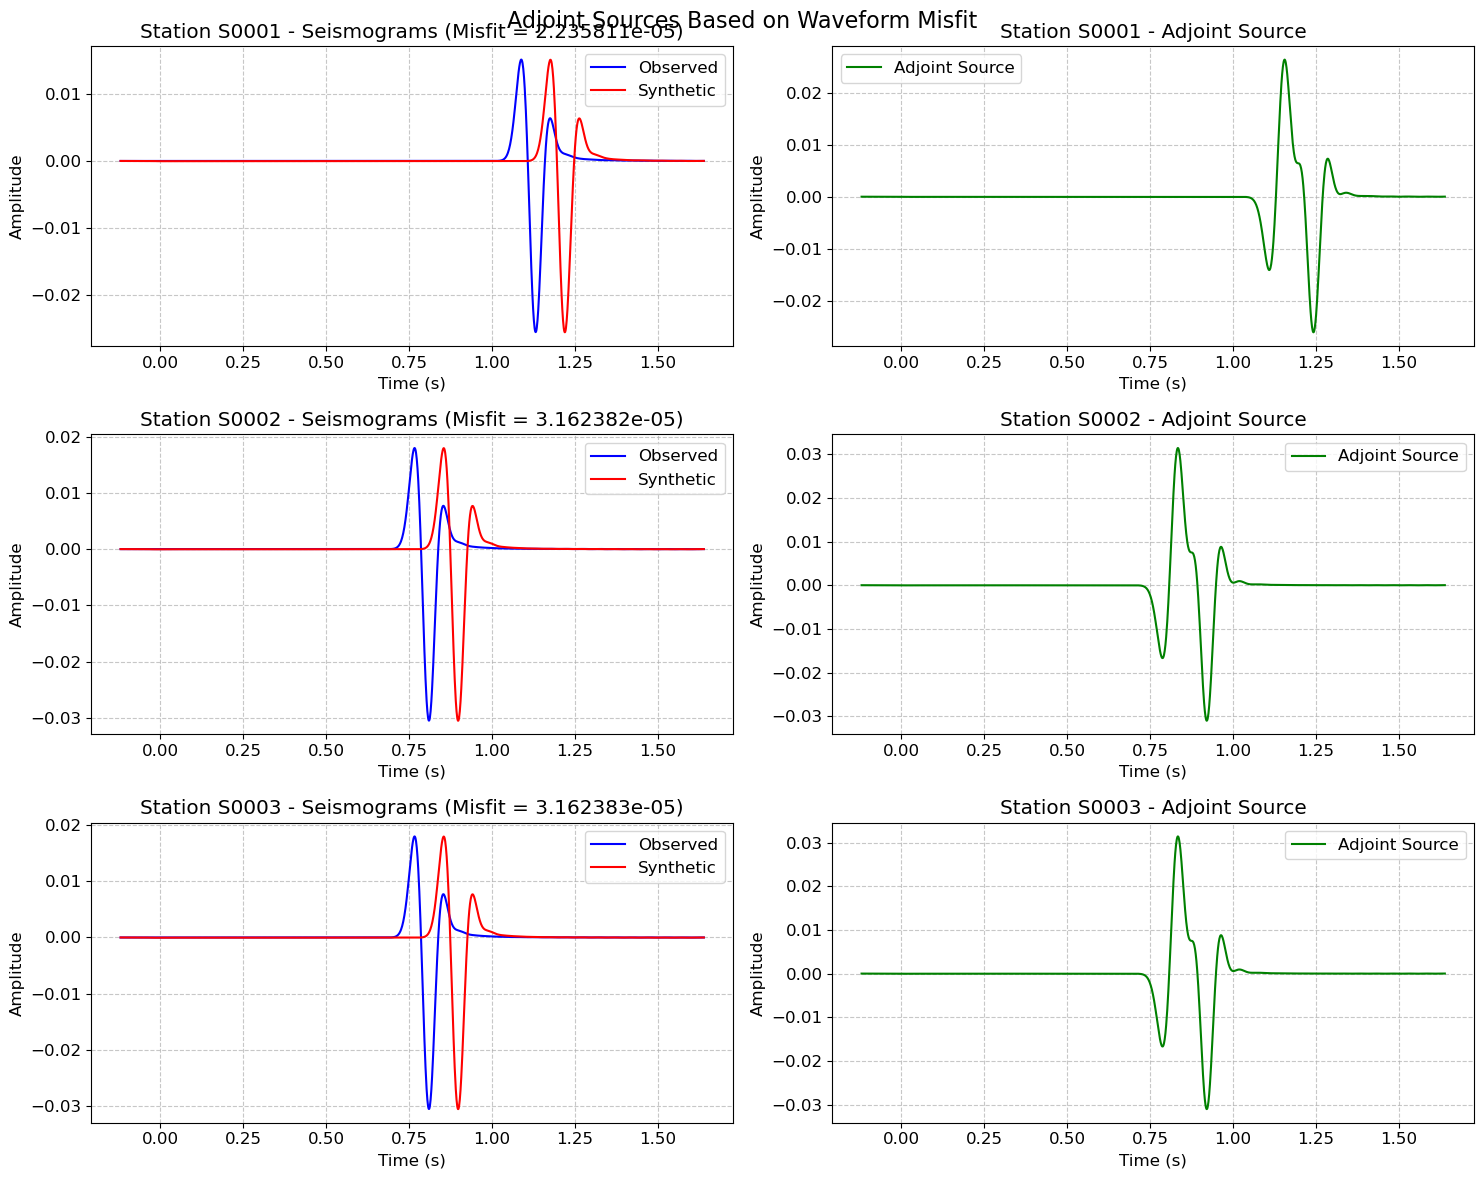

In [67]:
def compute_adjoint_sources(true_seismograms, init_seismograms):
    """Compute adjoint sources based on waveform misfit"""
    adjoint_sources = {}
    misfit_values = {}
    
    if not true_seismograms or not init_seismograms:
        print("Missing seismogram data for adjoint source computation")
        return adjoint_sources, misfit_values, 0.0
    
    # Get common station names
    common_stations = set(true_seismograms.keys()).intersection(set(init_seismograms.keys()))
    if not common_stations:
        print("No common stations between true and initial models")
        return adjoint_sources, misfit_values, 0.0
    
    for station_name in common_stations:
        true_trace = true_seismograms[station_name]
        init_trace = init_seismograms[station_name]
        
        # Compute waveform misfit
        try:
            misfit = simpson((true_trace.data - init_trace.data)**2, dx=true_trace.stats.delta) / 2.0
        except Exception as e:
            print(f"Error computing misfit for station {station_name}: {e}")
            continue
        
        # Create adjoint source as synthetic - observed
        adj_trace = init_trace.copy()
        adj_trace.data = init_trace.data - true_trace.data
        
        # Basic processing
        adj_trace.detrend("simple")
        adj_trace.taper(0.05)
        adj_trace.filter("bandpass", freqmin=0.01, freqmax=20)
        
        adjoint_sources[station_name] = adj_trace
        misfit_values[station_name] = misfit
    
    total_misfit = sum(misfit_values.values()) if misfit_values else 0.0
    
    return adjoint_sources, misfit_values, total_misfit

def plot_adjoint_sources(true_seismograms, init_seismograms, adjoint_sources, misfit_values, stations=None):
    """Plot observed, synthetic, and adjoint sources"""
    # Get common station names
    if not adjoint_sources:
        print("No adjoint sources to plot")
        return None, None
    
    common_stations = set(adjoint_sources.keys())
    if not common_stations:
        print("No adjoint sources to plot")
        return None, None
    
    # If stations list is provided, use it for ordering
    if stations:
        station_names = [s['name'] for s in stations if s['name'] in common_stations]
    else:
        station_names = sorted(list(common_stations))
    
    n_stations = len(station_names)
    if n_stations == 0:
        print("No stations to plot")
        return None, None
    
    # Create figure with subplots for each station
    fig, axes = plt.subplots(n_stations, 2, figsize=(15, 4*n_stations))
    if n_stations == 1:
        axes = axes.reshape(1, 2)  # Ensure 2D array for indexing
    
    # Plot each station's seismograms and adjoint source
    for i, station_name in enumerate(station_names):
        true_trace = true_seismograms[station_name]
        init_trace = init_seismograms[station_name]
        adj_trace = adjoint_sources[station_name]
        misfit = misfit_values.get(station_name, 0.0)
        
        # Left plot: observed and synthetic seismograms
        ax1 = axes[i, 0]
        time_true = true_trace.times() + true_trace.stats.b
        time_init = init_trace.times() + init_trace.stats.b
        
        ax1.plot(time_true, true_trace.data, 'b-', label='Observed')
        ax1.plot(time_init, init_trace.data, 'r-', label='Synthetic')
        
        ax1.set_title(f"Station {station_name} - Seismograms (Misfit = {misfit:.6e})")
        ax1.set_ylabel("Amplitude")
        ax1.set_xlabel("Time (s)")
        ax1.grid(True, linestyle='--', alpha=0.7)
        ax1.legend()
        
        # Right plot: adjoint source
        ax2 = axes[i, 1]
        time_adj = adj_trace.times() + adj_trace.stats.b
        
        ax2.plot(time_adj, adj_trace.data, 'g-', label='Adjoint Source')
        
        ax2.set_title(f"Station {station_name} - Adjoint Source")
        ax2.set_ylabel("Amplitude")
        ax2.set_xlabel("Time (s)")
        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.legend()
    
    # Add overall title
    fig.suptitle(f"Adjoint Sources Based on Waveform Misfit", fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust for suptitle
    
    return fig, axes

# Compute adjoint sources if we have both true and initial data
adjoint_sources = {}
misfit_values = {}
total_misfit = 0.0

try:
    if true_seismograms and init_seismograms:
        adjoint_sources, misfit_values, total_misfit = compute_adjoint_sources(true_seismograms, init_seismograms)
        
        # Display total misfit
        if misfit_values:
            print(f"Total waveform misfit: {total_misfit:.6e}")
            
            # Plot adjoint sources
            fig_adj, axes_adj = plot_adjoint_sources(true_seismograms, init_seismograms, adjoint_sources, misfit_values, stations)
            if fig_adj:
                plt.show(fig_adj)
        else:
            print("No misfit values calculated")
    else:
        print("Insufficient data for adjoint source calculation")
except Exception as e:
    print(f"Error computing adjoint sources: {e}")

In [ ]:
def run_adjoint_simulation(data_dir, init_model_dir, true_model_dir, output_dir, 
                          adjoint_sources, bin_dir, stations):
    """
    Run an adjoint simulation using the adjoint sources computed from the misfit.
    
    Args:
        data_dir: Directory containing Par_file and other input files
        init_model_dir: Directory containing initial model results
        true_model_dir: Directory containing true model results
        output_dir: Directory to save adjoint simulation results
        adjoint_sources: Dictionary of adjoint source traces
        bin_dir: Directory containing SPECFEM2D binaries
        stations: List of station dictionaries
        
    Returns:
        Boolean indicating success or failure
    """
    if not data_dir or not os.path.exists(data_dir):
        print(f"Data directory not found: {data_dir}")
        return False
        
    if not init_model_dir or not os.path.exists(init_model_dir):
        print(f"Initial model directory not found: {init_model_dir}")
        return False
        
    if not output_dir:
        print("No output directory specified")
        return False
        
    if not adjoint_sources:
        print("No adjoint sources provided")
        return False
        
    if not bin_dir:
        # Try to find bin directory in a standard location if not provided
        possible_bin_dirs = [
            os.path.join(os.path.dirname(data_dir), "bin"),
            "/home/masa/specfem2d/bin",
            "/home/masan/specfem2d/bin"
        ]
        
        for dir_path in possible_bin_dirs:
            if os.path.exists(dir_path):
                bin_dir = dir_path
                print(f"Found binaries at: {bin_dir}")
                break
                
        if not bin_dir:
            print("Could not find SPECFEM2D binaries")
            return False
    
    try:
        # Create output directory if it doesn't exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
        # Create SEM directory for adjoint sources
        sem_dir = os.path.join(os.path.dirname(init_model_dir), "SEM")
        if not os.path.exists(sem_dir):
            os.makedirs(sem_dir)
            
        # Save adjoint sources
        print(f"Saving adjoint sources to {sem_dir}...")
        for station_name, adj_trace in adjoint_sources.items():
            # Find network code for this station
            network = next((s['network'] for s in stations if s['name'] == station_name), "AA")
            adj_file_name = f"{network}.{station_name}.BXY.adj"
            adj_file_path = os.path.join(sem_dir, adj_file_name)
            
            # Save adjoint source
            save_trace(adj_trace, adj_file_path)
            print(f"  Saved: {adj_file_name}")
            
        # Make a backup of original Par_file
        par_file_path = os.path.join(data_dir, "Par_file")
        par_file_backup = os.path.join(data_dir, "Par_file.bak")
        shutil.copy2(par_file_path, par_file_backup)
        print(f"Backed up original Par_file to {par_file_backup}")
            
        # Prepare Par_file for adjoint simulation
        print("Configuring Par_file for adjoint simulation...")
        
        # Read Par_file
        with open(par_file_path, 'r') as f:
            par_lines = f.readlines()
            
        # Modify simulation type to 3 (both forward and adjoint)
        # And ensure other required parameters are set correctly
        modified_params = False
        for i, line in enumerate(par_lines):
            if "SIMULATION_TYPE" in line and "=" in line:
                par_lines[i] = "SIMULATION_TYPE                 = 3\n"
                modified_params = True
            elif "SAVE_FORWARD" in line and "=" in line:
                par_lines[i] = "SAVE_FORWARD                    = .false.\n"
                modified_params = True
            # Make sure adjoint sources are read from SEM directory
            elif "SU_FORMAT" in line and "=" in line:
                par_lines[i] = "SU_FORMAT                       = .false.\n"
                modified_params = True
            elif "USE_BINARY_FOR_SEISMOGRAMS" in line and "=" in line:
                par_lines[i] = "USE_BINARY_FOR_SEISMOGRAMS      = .false.\n"
                modified_params = True
                
        if not modified_params:
            print("Warning: Could not find and modify all required parameters in Par_file")
            print("Please check the Par_file manually")
            
        # Write modified Par_file
        with open(par_file_path, 'w') as f:
            f.writelines(par_lines)
        
        # First, we need to prepare the OUTPUT_FILES directory
        print("Preparing OUTPUT_FILES directory for adjoint simulation...")
        specfem_output = os.path.join(os.path.dirname(init_model_dir), "OUTPUT_FILES")
        
        # Clear existing OUTPUT_FILES if it exists
        if os.path.exists(specfem_output):
            shutil.rmtree(specfem_output)
        os.makedirs(specfem_output)
        
        # Copy all files from initial model directory to OUTPUT_FILES
        print("Copying initial model files to OUTPUT_FILES...")
        for file_name in os.listdir(init_model_dir):
            file_path = os.path.join(init_model_dir, file_name)
            if os.path.isfile(file_path):
                shutil.copy2(file_path, os.path.join(specfem_output, file_name))
                
        # Also copy the Database file which is needed for adjoint simulation
        database_file = os.path.join(init_model_dir, "Database00000.bin")
        if os.path.exists(database_file):
            shutil.copy2(database_file, os.path.join(specfem_output, "Database00000.bin"))
            print("Copied Database00000.bin to OUTPUT_FILES")
                
        # Run the adjoint simulation
        print("Running adjoint simulation...")
        
        # Change to the correct directory before running the commands
        orig_dir = os.getcwd()
        base_dir = os.path.dirname(data_dir)
        os.chdir(base_dir)
        print(f"Changed to directory: {base_dir}")
        
        # Run mesher with detailed output
        print("  Running mesher...")
        mesher_cmd = os.path.join(bin_dir, "xmeshfem2D")
        mesher_log = os.path.join(specfem_output, "mesher_log.txt")
        
        # Show command for debugging
        print(f"  Executing: {mesher_cmd} > {mesher_log}")
        retcode = os.system(f"{mesher_cmd} > {mesher_log} 2>&1")
        
        if retcode != 0:
            print(f"  Mesher failed with return code {retcode}")
            print("  Displaying last 10 lines of mesher log:")
            if os.path.exists(mesher_log):
                with open(mesher_log, 'r') as f:
                    lines = f.readlines()
                    for line in lines[-10:]:
                        print(f"    {line.rstrip()}")
            else:
                print("  No mesher log file found")
            
            # Restore Par_file from backup and return
            shutil.copy2(par_file_backup, par_file_path)
            print("Restored original Par_file from backup")
            os.chdir(orig_dir)
            return False
        
        # Run solver with detailed output
        print("  Running solver...")
        solver_cmd = os.path.join(bin_dir, "xspecfem2D")
        solver_log = os.path.join(specfem_output, "solver_log.txt")
        
        # Show command for debugging
        print(f"  Executing: {solver_cmd} > {solver_log}")
        retcode = os.system(f"{solver_cmd} > {solver_log} 2>&1")
        
        if retcode != 0:
            print(f"  Solver failed with return code {retcode}")
            print("  Displaying last 10 lines of solver log:")
            if os.path.exists(solver_log):
                with open(solver_log, 'r') as f:
                    lines = f.readlines()
                    for line in lines[-10:]:
                        print(f"    {line.rstrip()}")
            else:
                print("  No solver log file found")
            
            # Restore Par_file from backup and return
            shutil.copy2(par_file_backup, par_file_path)
            print("Restored original Par_file from backup")
            os.chdir(orig_dir)
            return False
        
        # Check if kernel file was generated
        kernel_file = os.path.join(specfem_output, "proc000000_rhop_alpha_beta_kernel.dat")
        if os.path.exists(kernel_file):
            print("Adjoint simulation completed successfully!")
            
            # Move OUTPUT_FILES to the specified output directory
            if os.path.exists(output_dir):
                shutil.rmtree(output_dir)
            shutil.move(specfem_output, output_dir)
            
            # Restore original Par_file
            shutil.copy2(par_file_backup, par_file_path)
            print("Restored original Par_file from backup")
            
            # Return to original directory
            os.chdir(orig_dir)
            return True
        else:
            print("Adjoint simulation failed to generate kernel file")
            print("Please check the simulation logs for more details")
            
            # Restore original Par_file
            shutil.copy2(par_file_backup, par_file_path)
            print("Restored original Par_file from backup")
            
            # Return to original directory
            os.chdir(orig_dir)
            return False
            
    except Exception as e:
        print(f"Error running adjoint simulation: {e}")
        import traceback
        traceback.print_exc()
        
        # Try to restore Par_file if possible
        par_file_backup = os.path.join(data_dir, "Par_file.bak")
        if os.path.exists(par_file_backup):
            shutil.copy2(par_file_backup, os.path.join(data_dir, "Par_file"))
            print("Restored original Par_file from backup after error")
        
        # Return to original directory
        if 'orig_dir' in locals():
            os.chdir(orig_dir)
            
        return False

# Run adjoint simulation if we have all the necessary components
try:
    if MODEL_TRUE_DIR and MODEL_INIT_DIR and DATA_DIR and adjoint_sources:
        MODEL_ADJ_DIR = os.path.join(BASE_DIR, "OUTPUT_FILES_ADJ")
        
        print("\nRunning adjoint simulation to generate sensitivity kernels...")
        # First, try to locate the binary directory
        possible_bin_dirs = [
            os.path.join(BASE_DIR, "bin"),
            os.path.join(os.path.dirname(BASE_DIR), "bin"),
            "/home/masa/specfem2d/bin",
            "/home/masan/specfem2d/bin"
        ]
        
        bin_dir = None
        for dir_path in possible_bin_dirs:
            if os.path.exists(dir_path):
                mesher_path = os.path.join(dir_path, "xmeshfem2D")
                solver_path = os.path.join(dir_path, "xspecfem2D")
                
                if os.path.exists(mesher_path) and os.path.exists(solver_path):
                    bin_dir = dir_path
                    print(f"Found SPECFEM2D binaries in: {bin_dir}")
                    break
        
        if bin_dir:
            success = run_adjoint_simulation(DATA_DIR, MODEL_INIT_DIR, MODEL_TRUE_DIR, 
                                           MODEL_ADJ_DIR, adjoint_sources, bin_dir, stations)
            
            if success:
                print(f"Adjoint simulation completed successfully. Results saved to: {MODEL_ADJ_DIR}")
                # Now let's check for kernel files
                kernel_file = os.path.join(MODEL_ADJ_DIR, "proc000000_rhop_alpha_beta_kernel.dat")
                if os.path.exists(kernel_file):
                    print("Kernel file found! Now we can visualize the sensitivity kernels.")
                else:
                    print("Kernel file not found in adjoint output directory.")
            else:
                print("Failed to run adjoint simulation.")
        else:
            print("Could not find SPECFEM2D binaries. Cannot run adjoint simulation.")
            print("Please make sure SPECFEM2D is installed and correctly configured.")
    else:
        if not MODEL_TRUE_DIR:
            print("True model directory not found. Cannot run adjoint simulation.")
        if not MODEL_INIT_DIR:
            print("Initial model directory not found. Cannot run adjoint simulation.")
        if not DATA_DIR:
            print("Data directory not found. Cannot run adjoint simulation.")
        if not adjoint_sources:
            print("No adjoint sources computed. Cannot run adjoint simulation.")
except Exception as e:
    print(f"Error preparing adjoint simulation: {e}")

In [74]:
def load_kernel_data(kernel_file):
    """Load kernel data from file"""
    if not kernel_file or not os.path.exists(kernel_file):
        print(f"Kernel file not found: {kernel_file}")
        return None, None, None, None, None
    
    try:
        data = np.loadtxt(kernel_file)
        x = data[:, 0]  # first column: x
        z = data[:, 1]  # second column: z
        rhop = data[:, 2]  # third column: rhop (density)
        alpha = data[:, 3]  # fourth column: alpha (P-velocity)
        beta = data[:, 4]  # fifth column: beta (S-velocity)
        return x, z, rhop, alpha, beta
    except Exception as e:
        print(f"Error loading kernel data: {e}")
        return None, None, None, None, None

def plot_kernel(x, z, kernel_data, kernel_type, stations=None, source_x=None, source_z=None):
    """Plot a sensitivity kernel"""
    if x is None or z is None or kernel_data is None:
        print("Cannot plot kernel: missing data")
        return None, None
    
    # Grid the data for plotting
    X, Z, K = grid(x, z, kernel_data)
    
    # Create colormap
    cmap = 'seismic_r'
    
    # Determine appropriate colormap scale
    vmax = np.max(np.abs(K)) * 0.8  # Scale to 80% of max for better visualization
    vmin = -vmax
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot kernel
    im = ax.imshow(K, vmax=vmax, vmin=vmin, extent=[x.min(), x.max(), z.min(), z.max()],
                  cmap=cmap, origin='lower')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(f"{kernel_type} Kernel")
    
    # Add source
    if source_x is not None and source_z is not None:
        ax.scatter(source_x, source_z, s=200, marker='*', color='black', edgecolor='white', 
                  label='Source', zorder=5)
    
    # Add receivers
    if stations:
        for station in stations:
            ax.scatter(station['x'], station['z'], s=80, marker='v', color='black', 
                      edgecolor='white', label='_nolegend_', zorder=5)
        # Add one entry for the legend
        ax.scatter([], [], s=80, marker='v', color='black', edgecolor='white', label='Receivers')
    
    # Set labels and title
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')
    ax.set_title(f"{kernel_type} Sensitivity Kernel")
    
    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    plt.tight_layout()
    return fig, ax

def plot_kernel_comparison():
    """Plot all kernel types side by side for comparison"""
    # Check if adjoint results are available
    if not MODEL_ADJ_DIR or not os.path.exists(MODEL_ADJ_DIR):
        print("Adjoint results directory not found")
        return None, None
    
    kernel_file = os.path.join(MODEL_ADJ_DIR, "proc000000_rhop_alpha_beta_kernel.dat")
    if not os.path.exists(kernel_file):
        print(f"Kernel file not found: {kernel_file}")
        return None, None
    
    # Load kernel data
    x, z, rhop, alpha, beta = load_kernel_data(kernel_file)
    if x is None:
        return None, None
    
    # Create a figure with three subplots (one for each kernel type)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Define kernel types and labels
    kernel_types = [
        (rhop, "Density (ρ)"),
        (alpha, "P-velocity (α)"),
        (beta, "S-velocity (β)")
    ]
    
    # Plot each kernel type
    for i, (kernel_data, kernel_label) in enumerate(kernel_types):
        # Grid the data
        X, Z, K = grid(x, z, kernel_data)
        
        # Determine colormap scale
        vmax = np.max(np.abs(K)) * 0.8
        vmin = -vmax
        
        # Plot kernel
        im = axes[i].imshow(K, vmax=vmax, vmin=vmin, 
                          extent=[x.min(), x.max(), z.min(), z.max()],
                          cmap='seismic_r', origin='lower')
        
        # Add colorbar
        cbar = fig.colorbar(im, ax=axes[i])
        cbar.set_label(f"{kernel_label} Kernel")
        
        # Add title
        axes[i].set_title(f"{kernel_label} Sensitivity Kernel")
        
        # Add source and receivers
        if 'source_x' in globals() and 'source_z' in globals():
            axes[i].scatter(source_x, source_z, s=150, marker='*', 
                           color='black', edgecolor='white', zorder=5)
        
        if 'stations' in globals() and stations:
            for station in stations:
                axes[i].scatter(station['x'], station['z'], s=60, marker='v', 
                               color='black', edgecolor='white', zorder=5)
        
        # Set labels
        axes[i].set_xlabel('X (m)')
        if i == 0:
            axes[i].set_ylabel('Z (m)')
    
    # Add overall title
    if wave_mode == 'SH':
        fig.suptitle("Sensitivity Kernels (SH Waves)", fontsize=16)
    else:
        fig.suptitle("Sensitivity Kernels (P-SV Waves)", fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return fig, axes

# Check for adjoint results and visualize kernels
print("\nChecking for adjoint simulation results...")
if MODEL_ADJ_DIR and os.path.exists(MODEL_ADJ_DIR):
    kernel_file = os.path.join(MODEL_ADJ_DIR, "proc000000_rhop_alpha_beta_kernel.dat")
    if os.path.exists(kernel_file):
        print("Kernel file found! Visualizing sensitivity kernels...")
        
        # Plot side-by-side comparison of all kernels
        fig_kernels, axes_kernels = plot_kernel_comparison()
        if fig_kernels:
            plt.show(fig_kernels)
            
            # If we're in SH mode, show detailed beta kernel plot
            if wave_mode == 'SH':
                # Load kernel data
                x, z, _, _, beta = load_kernel_data(kernel_file)
                if x is not None:
                    print("\nDetailed S-velocity (β) kernel for SH waves:")
                    fig_beta, ax_beta = plot_kernel(x, z, beta, "S-velocity (β)", 
                                                  stations, source_x, source_z)
                    if fig_beta:
                        plt.show(fig_beta)
        else:
            print("Failed to visualize kernels.")
    else:
        print(f"Kernel file not found: {kernel_file}")
        print("Please run the adjoint simulation first to generate kernels.")
else:
    print("Adjoint simulation results not found.")
    print("Please run the adjoint simulation first to generate kernels.")


Checking for adjoint simulation results...
Kernel file not found: /home/masa/FWI_MAH575/JupyterNotebooks/work/ExampleKernelMultiReceiver/OUTPUT_FILES_ADJ/proc000000_rhop_alpha_beta_kernel.dat
Please run the adjoint simulation first to generate kernels.


In [75]:
def create_simulation_summary():
    """Create a summary of the simulation setup and results"""
    # Simulation mode
    sim_type_desc = {
        1: "Forward simulation only",
        2: "Adjoint simulation only (not typically used)",
        3: "Forward and adjoint simulation"
    }
    sim_description = sim_type_desc.get(sim_type, "Unknown")
    
    # Wave type
    wave_description = wave_mode
    if wave_mode == 'SH':
        wave_details = "SH (horizontally polarized shear) waves"
    else:
        wave_details = "P-SV (compressional and vertically polarized shear) waves"
    
    # Source type
    source_description = get_source_type_description(source_type)
    
    # Create HTML output
    html = "<h2>SPECFEM2D Simulation Summary</h2>"
    
    # Simulation configuration
    html += "<h3>Simulation Configuration</h3>"
    html += "<ul>"
    html += f"<li><strong>Simulation type:</strong> {sim_description}</li>"
    html += f"<li><strong>Wave mode:</strong> {wave_description} ({wave_details})</li>"
    html += f"<li><strong>Source type:</strong> {source_description}</li>"
    
    if 'time_function' in globals() and time_function != 'Unknown':
        html += f"<li><strong>Source time function:</strong> {get_time_function_description(time_function)}</li>"
    
    if 'frequency' in globals() and frequency > 0:
        html += f"<li><strong>Dominant frequency:</strong> {frequency} Hz</li>"
    
    if 'stations' in globals() and stations:
        html += f"<li><strong>Number of receivers:</strong> {len(stations)}</li>"
    
    html += "</ul>"
    
    # Model properties
    html += "<h3>Model Properties</h3>"
    html += "<ul>"
    
    if 'parameters' in globals() and parameters:
        if 'xmin' in parameters and 'xmax' in parameters:
            html += f"<li><strong>Model dimensions:</strong> {parameters.get('xmin', '0').replace('d0', '')} to {parameters.get('xmax', '0').replace('d0', '')} m (horizontal)</li>"
    
    if 'resolution_metrics' in globals() and resolution_metrics:
        html += f"<li><strong>Minimum resolvable period:</strong> {resolution_metrics['min_period']:.4f} seconds</li>"
        html += f"<li><strong>Maximum resolvable frequency:</strong> {resolution_metrics['max_frequency']:.2f} Hz</li>"
    
    html += "</ul>"
    
    # Interpretation
    html += "<h3>Interpretation</h3>"
    html += "<p>Based on the simulation results, we can make the following observations:</p>"
    html += "<ul>"
    
    # Model comparison
    if MODEL_TRUE_DIR and MODEL_INIT_DIR:
        html += "<li>The simulation includes both true and initial models with associated velocity fields.</li>"
    elif MODEL_TRUE_DIR:
        html += "<li>Only the true model is available for analysis.</li>"
    
    # Seismogram comparison
    if 'true_seismograms' in globals() and 'init_seismograms' in globals() and true_seismograms and init_seismograms:
        html += "<li>The seismograms show wave propagation between the source and receivers.</li>"
    
    # Misfit
    if 'total_misfit' in globals() and total_misfit > 0:
        html += f"<li>The total waveform misfit between true and initial models is {total_misfit:.6e}.</li>"
    
    # Kernel interpretation
    if MODEL_ADJ_DIR and os.path.exists(MODEL_ADJ_DIR):
        if wave_mode == 'SH':
            html += "<li>The sensitivity kernel shows areas where changes in S-wave velocity would most affect the misfit.</li>"
        else:
            html += "<li>The sensitivity kernels show areas where changes in P-wave velocity, S-wave velocity, and density would most affect the misfit.</li>"
    
    html += "</ul>"
    
    html += "<p>For full interpretation, consider:</p>"
    html += "<ul>"
    html += "<li>The first-arrival traveltimes and amplitudes in the seismograms</li>"
    html += "<li>The spatial patterns in the sensitivity kernels and how they relate to the source-receiver geometry</li>"
    html += "<li>Which areas show positive vs. negative sensitivity, indicating where velocity should be increased or decreased to reduce misfit</li>"
    html += "</ul>"
    
    return html

# Create and display summary
try:
    summary_html = create_simulation_summary()
    display(HTML(summary_html))
except Exception as e:
    print(f"Error creating summary: {e}")
    display(HTML("<h2>SPECFEM2D Simulation Summary</h2><p>Insufficient data available to create a complete summary.</p>"))

In [ ]:
def plot_model(model_dir, model_type='vs', title=None, show_source=True, show_receivers=True):
    """Plot a velocity model with source and receiver locations"""
    x_coords_file = os.path.join(model_dir, "proc000000_x.bin")
    z_coords_file = os.path.join(model_dir, "proc000000_z.bin")
    
    if model_type.lower() == 'vs':
        model_file = os.path.join(model_dir, "proc000000_vs.bin")
        colorbar_label = "Vs (m/s)"
    elif model_type.lower() == 'vp':
        model_file = os.path.join(model_dir, "proc000000_vp.bin")
        colorbar_label = "Vp (m/s)"
    elif model_type.lower() == 'rho':
        model_file = os.path.join(model_dir, "proc000000_rho.bin")
        colorbar_label = "Density (kg/m³)"
    else:
        print(f"Unknown model type: {model_type}")
        return
    
    # Check if files exist
    for file in [x_coords_file, z_coords_file, model_file]:
        if not os.path.exists(file):
            print(f"File not found: {file}")
            return
    
    # Load coordinate and model data
    x = FunctionsPlotBin.read_fortran(x_coords_file)
    z = FunctionsPlotBin.read_fortran(z_coords_file)
    model_data = FunctionsPlotBin.read_fortran(model_file)
    
    # Create mesh grid for plotting
    X, Z, MODEL = grid(x, z, model_data)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot model
    im = ax.imshow(MODEL, extent=[x.min(), x.max(), z.min(), z.max()],
                  cmap='viridis', origin='lower')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(colorbar_label)
    
    # Add source
    if show_source:
        ax.scatter(source_x, source_z, s=200, marker='*', color='red', edgecolor='white', 
                  label='Source', zorder=5)
    
    # Add receivers
    if show_receivers and stations:
        for station in stations:
            ax.scatter(station['x'], station['z'], s=80, marker='v', color='blue', 
                      edgecolor='white', label='_nolegend_', zorder=5)
        # Add one entry for the legend
        ax.scatter([], [], s=80, marker='v', color='blue', edgecolor='white', label='Receivers')
    
    # Set labels and title
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f"{model_type.upper()} Model")
    
    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='best')
    
    plt.tight_layout()
    return fig, ax

# Plot true and initial Vs models
fig_true, ax_true = plot_model(MODEL_TRUE_DIR, model_type='vs', title='True Vs Model')
fig_init, ax_init = plot_model(MODEL_INIT_DIR, model_type='vs', title='Initial Vs Model')

## 6. Seismogram Analysis

Load and plot seismograms from both true and initial models

In [ ]:
def load_and_process_seismograms(model_dir, stations, component='BXY'):
    """Load and process seismograms for all stations"""
    seismograms = {}
    
    for station in stations:
        station_code = f"{station['network']}.{station['name']}.{component}.semd"
        seismogram_file = os.path.join(model_dir, station_code)
        
        if not os.path.exists(seismogram_file):
            print(f"Seismogram file not found: {seismogram_file}")
            continue
        
        # Read seismogram
        trace = read_trace(seismogram_file)
        
        # Basic processing
        trace.detrend("simple")
        trace.taper(0.05)
        trace.filter("bandpass", freqmin=0.01, freqmax=20)
        
        seismograms[station['name']] = trace
    
    return seismograms

def plot_seismograms(true_seismograms, init_seismograms, stations=None):
    """Plot comparison of true and initial seismograms"""
    if not true_seismograms or not init_seismograms:
        print("No seismograms to plot")
        return
    
    # Get common station names between true and initial models
    common_stations = set(true_seismograms.keys()).intersection(set(init_seismograms.keys()))
    if not common_stations:
        print("No common stations between true and initial models")
        return
    
    # If stations list is provided, use it for ordering
    if stations:
        station_names = [s['name'] for s in stations if s['name'] in common_stations]
    else:
        station_names = sorted(list(common_stations))
    
    n_stations = len(station_names)
    
    # Create figure with subplots for each station
    fig, axes = plt.subplots(n_stations, 1, figsize=(12, 3*n_stations), sharex=True)
    if n_stations == 1:
        axes = [axes]  # Convert to list for consistent indexing
    
    # Plot each station's seismograms
    for i, station_name in enumerate(station_names):
        true_trace = true_seismograms[station_name]
        init_trace = init_seismograms[station_name]
        
        # Plot traces
        ax = axes[i]
        time_true = true_trace.times() + true_trace.stats.b
        time_init = init_trace.times() + init_trace.stats.b
        
        ax.plot(time_true, true_trace.data, 'b-', label='True')
        ax.plot(time_init, init_trace.data, 'r-', label='Initial')
        
        # Set titles and labels
        ax.set_title(f"Station {station_name}")
        ax.set_ylabel("Amplitude")
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Add legend only to the first subplot
        if i == 0:
            ax.legend()
    
    # Set common x-label
    axes[-1].set_xlabel("Time (s)")
    
    # Add overall title
    fig.suptitle("Comparison of Seismograms: True vs Initial Model", fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust for suptitle
    
    return fig, axes

# Load seismograms for true and initial models
true_seismograms = load_and_process_seismograms(MODEL_TRUE_DIR, stations)
init_seismograms = load_and_process_seismograms(MODEL_INIT_DIR, stations)

# Plot seismograms
fig_seismo, axes_seismo = plot_seismograms(true_seismograms, init_seismograms, stations)

## 7. Adjoint Source Computation

Calculate and visualize adjoint sources based on waveform misfit

In [ ]:
def compute_adjoint_sources(true_seismograms, init_seismograms):
    """Compute adjoint sources based on waveform misfit"""
    adjoint_sources = {}
    misfit_values = {}
    
    # Get common station names
    common_stations = set(true_seismograms.keys()).intersection(set(init_seismograms.keys()))
    
    for station_name in common_stations:
        true_trace = true_seismograms[station_name]
        init_trace = init_seismograms[station_name]
        
        # Compute waveform misfit
        try:
            misfit = simpson((true_trace.data - init_trace.data)**2, dx=true_trace.stats.delta) / 2.0
        except Exception as e:
            print(f"Error computing misfit for station {station_name}: {e}")
            continue
        
        # Create adjoint source as synthetic - observed
        adj_trace = init_trace.copy()
        adj_trace.data = init_trace.data - true_trace.data
        
        # Basic processing
        adj_trace.detrend("simple")
        adj_trace.taper(0.05)
        adj_trace.filter("bandpass", freqmin=0.01, freqmax=20)
        
        adjoint_sources[station_name] = adj_trace
        misfit_values[station_name] = misfit
    
    total_misfit = sum(misfit_values.values())
    
    return adjoint_sources, misfit_values, total_misfit

def plot_adjoint_sources(true_seismograms, init_seismograms, adjoint_sources, misfit_values, stations=None):
    """Plot observed, synthetic, and adjoint sources"""
    # Get common station names
    common_stations = set(adjoint_sources.keys())
    if not common_stations:
        print("No adjoint sources to plot")
        return
    
    # If stations list is provided, use it for ordering
    if stations:
        station_names = [s['name'] for s in stations if s['name'] in common_stations]
    else:
        station_names = sorted(list(common_stations))
    
    n_stations = len(station_names)
    
    # Create figure with subplots for each station
    fig, axes = plt.subplots(n_stations, 2, figsize=(15, 4*n_stations))
    if n_stations == 1:
        axes = axes.reshape(1, 2)  # Ensure 2D array for indexing
    
    # Plot each station's seismograms and adjoint source
    for i, station_name in enumerate(station_names):
        true_trace = true_seismograms[station_name]
        init_trace = init_seismograms[station_name]
        adj_trace = adjoint_sources[station_name]
        misfit = misfit_values[station_name]
        
        # Left plot: observed and synthetic seismograms
        ax1 = axes[i, 0]
        time_true = true_trace.times() + true_trace.stats.b
        time_init = init_trace.times() + init_trace.stats.b
        
        ax1.plot(time_true, true_trace.data, 'b-', label='Observed')
        ax1.plot(time_init, init_trace.data, 'r-', label='Synthetic')
        
        ax1.set_title(f"Station {station_name} - Seismograms (Misfit = {misfit:.6e})")
        ax1.set_ylabel("Amplitude")
        ax1.set_xlabel("Time (s)")
        ax1.grid(True, linestyle='--', alpha=0.7)
        ax1.legend()
        
        # Right plot: adjoint source
        ax2 = axes[i, 1]
        time_adj = adj_trace.times() + adj_trace.stats.b
        
        ax2.plot(time_adj, adj_trace.data, 'g-', label='Adjoint Source')
        
        ax2.set_title(f"Station {station_name} - Adjoint Source")
        ax2.set_ylabel("Amplitude")
        ax2.set_xlabel("Time (s)")
        ax2.grid(True, linestyle='--', alpha=0.7)
        ax2.legend()
    
    # Add overall title
    fig.suptitle(f"Adjoint Sources Based on Waveform Misfit", fontsize=16)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust for suptitle
    
    return fig, axes

# Compute adjoint sources
adjoint_sources, misfit_values, total_misfit = compute_adjoint_sources(true_seismograms, init_seismograms)

# Display total misfit
print(f"Total waveform misfit: {total_misfit:.6e}")

# Plot adjoint sources
fig_adj, axes_adj = plot_adjoint_sources(true_seismograms, init_seismograms, adjoint_sources, misfit_values, stations)

## 8. Sensitivity Kernel Visualization

Display the computed kernels if available

In [ ]:
def load_kernel_data(kernel_file):
    """Load kernel data from file"""
    if not os.path.exists(kernel_file):
        print(f"Kernel file not found: {kernel_file}")
        return None, None, None, None, None
    
    try:
        data = np.loadtxt(kernel_file)
        x = data[:, 0]  # first column: x
        z = data[:, 1]  # second column: z
        rhop = data[:, 2]  # third column: rhop (density)
        alpha = data[:, 3]  # fourth column: alpha (P-velocity)
        beta = data[:, 4]  # fifth column: beta (S-velocity)
        return x, z, rhop, alpha, beta
    except Exception as e:
        print(f"Error loading kernel data: {e}")
        return None, None, None, None, None

def plot_kernel(x, z, kernel_data, kernel_type, stations=None, source_x=None, source_z=None):
    """Plot a sensitivity kernel"""
    if x is None or z is None or kernel_data is None:
        print("Cannot plot kernel: missing data")
        return
    
    # Grid the data for plotting
    X, Z, K = grid(x, z, kernel_data)
    
    # Create colormap
    cmap = 'seismic_r'
    
    # Determine appropriate colormap scale
    vmax = np.max(np.abs(K)) * 0.8  # Scale to 80% of max for better visualization
    vmin = -vmax
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot kernel
    im = ax.imshow(K, vmax=vmax, vmin=vmin, extent=[x.min(), x.max(), z.min(), z.max()],
                  cmap=cmap, origin='lower')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(f"{kernel_type} Kernel")
    
    # Add source
    if source_x is not None and source_z is not None:
        ax.scatter(source_x, source_z, s=200, marker='*', color='black', edgecolor='white', 
                  label='Source', zorder=5)
    
    # Add receivers
    if stations:
        for station in stations:
            ax.scatter(station['x'], station['z'], s=80, marker='v', color='black', 
                      edgecolor='white', label='_nolegend_', zorder=5)
        # Add one entry for the legend
        ax.scatter([], [], s=80, marker='v', color='black', edgecolor='white', label='Receivers')
    
    # Set labels and title
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')
    ax.set_title(f"{kernel_type} Sensitivity Kernel")
    
    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    plt.tight_layout()
    return fig, ax

# Check if adjoint results are available
if MODEL_ADJ_DIR and os.path.exists(MODEL_ADJ_DIR):
    kernel_file = os.path.join(MODEL_ADJ_DIR, "proc000000_rhop_alpha_beta_kernel.dat")
    if os.path.exists(kernel_file):
        # Load kernel data
        x, z, rhop, alpha, beta = load_kernel_data(kernel_file)
        
        # Plot kernels
        if wave_mode == 'SH':
            # For SH waves, only the beta (Vs) kernel is relevant
            fig_beta, ax_beta = plot_kernel(x, z, beta, "Beta (Vs)", stations, source_x, source_z)
            print("SH wave simulation - Displaying Beta (Vs) kernel")
        else:  # P-SV mode
            # For P-SV waves, both alpha (Vp) and beta (Vs) kernels are relevant
            fig_alpha, ax_alpha = plot_kernel(x, z, alpha, "Alpha (Vp)", stations, source_x, source_z)
            fig_beta, ax_beta = plot_kernel(x, z, beta, "Beta (Vs)", stations, source_x, source_z)
            fig_rhop, ax_rhop = plot_kernel(x, z, rhop, "Density", stations, source_x, source_z)
            print("P-SV wave simulation - Displaying Alpha (Vp), Beta (Vs), and Density kernels")
    else:
        print(f"Kernel file not found: {kernel_file}")
else:
    print("Adjoint simulation results not found. Kernels cannot be displayed.")

## 9. Model Resolution Analysis

Calculate and display model resolution metrics

In [ ]:
def calculate_minimum_period(model_dir, parameters):
    """Calculate the minimum resolvable period based on mesh resolution"""
    # Load velocity model
    x_coords_file = os.path.join(model_dir, "proc000000_x.bin")
    z_coords_file = os.path.join(model_dir, "proc000000_z.bin")
    vs_file = os.path.join(model_dir, "proc000000_vs.bin")
    
    if not all(os.path.exists(f) for f in [x_coords_file, z_coords_file, vs_file]):
        print("Required model files not found")
        return None
    
    # Load model data
    x = FunctionsPlotBin.read_fortran(x_coords_file)
    z = FunctionsPlotBin.read_fortran(z_coords_file)
    vs = FunctionsPlotBin.read_fortran(vs_file)
    
    # Estimate element size
    nx = int(parameters.get('nx', '0'))
    xmin = float(parameters.get('xmin', '0'))
    xmax = float(parameters.get('xmax', '0'))
    
    if nx > 0 and xmax > xmin:
        element_size = (xmax - xmin) / nx
    else:
        # Estimate from grid data
        x_sorted = np.sort(np.unique(x))
        dx = np.diff(x_sorted)
        element_size = np.mean(dx[dx > 0])  # Average non-zero differences
    
    # Get minimum velocity
    min_vs = np.min(vs[vs > 0])  # Minimum non-zero velocity
    
    # SPECFEM uses polynomial basis functions of degree NGLL-1
    # (NGLL is typically 5, so polynomial degree is 4)
    # This gives elements with about 5 points per wavelength
    # for proper resolution
    points_per_wavelength = 5
    
    # Calculate minimum resolvable wavelength (in meters)
    min_wavelength = element_size * points_per_wavelength
    
    # Calculate minimum resolvable period (in seconds)
    min_period = min_wavelength / min_vs
    
    # Convert to frequency (Hz)
    max_frequency = 1.0 / min_period
    
    return {
        'element_size': element_size,
        'min_vs': min_vs,
        'min_wavelength': min_wavelength,
        'min_period': min_period,
        'max_frequency': max_frequency
    }

def extract_filter_frequencies(seismogram):
    """Extract corner frequencies of applied bandpass filter"""
    if not seismogram:
        return None, None
    
    # Get the first seismogram in the dictionary
    trace = list(seismogram.values())[0]
    
    # Check processing history for filter information
    freqmin = None
    freqmax = None
    
    if hasattr(trace, 'stats') and hasattr(trace.stats, 'processing'):
        for proc in trace.stats.processing:
            if 'filter' in proc.lower() and 'freqmin' in proc and 'freqmax' in proc:
                # Extract frequencies from processing string
                freqmin_match = re.search(r'freqmin=([\d.]+)', proc)
                freqmax_match = re.search(r'freqmax=([\d.]+)', proc)
                
                if freqmin_match and freqmax_match:
                    freqmin = float(freqmin_match.group(1))
                    freqmax = float(freqmax_match.group(1))
                    break
    
    return freqmin, freqmax

# Calculate model resolution metrics
resolution_metrics = calculate_minimum_period(MODEL_INIT_DIR, parameters)

if resolution_metrics:
    print("Model Resolution Metrics:")
    print(f"  Average element size: {resolution_metrics['element_size']:.2f} meters")
    print(f"  Minimum S-wave velocity: {resolution_metrics['min_vs']:.2f} m/s")
    print(f"  Minimum resolvable wavelength: {resolution_metrics['min_wavelength']:.2f} meters")
    print(f"  Minimum resolvable period: {resolution_metrics['min_period']:.4f} seconds")
    print(f"  Maximum resolvable frequency: {resolution_metrics['max_frequency']:.2f} Hz")

# Extract filter corner frequencies
freqmin, freqmax = extract_filter_frequencies(true_seismograms)
if freqmin is not None and freqmax is not None:
    print("\nSeismogram Filter Parameters:")
    print(f"  Corner frequencies of bandpass filter: {freqmin:.2f} - {freqmax:.2f} Hz")
    
    # Compare with source frequency
    print(f"  Source dominant frequency: {frequency:.2f} Hz")
    
    if resolution_metrics:
        # Check if simulation can resolve the frequencies
        if freqmax > resolution_metrics['max_frequency']:
            print(f"  Warning: Maximum filter frequency ({freqmax:.2f} Hz) exceeds the maximum resolvable frequency ({resolution_metrics['max_frequency']:.2f} Hz)")
        else:
            print(f"  Verification: Maximum filter frequency ({freqmax:.2f} Hz) is within the resolvable range ({resolution_metrics['max_frequency']:.2f} Hz)")

## 10. Summary and Interpretation

Provide an overall interpretation of the simulation results

In [ ]:
def create_simulation_summary():
    """Create a summary of the simulation setup and results"""
    # Simulation mode
    sim_type_desc = {
        1: "Forward simulation only",
        2: "Adjoint simulation only (not typically used)",
        3: "Forward and adjoint simulation"
    }
    sim_description = sim_type_desc.get(sim_type, "Unknown")
    
    # Wave type
    wave_description = wave_mode
    if wave_mode == 'SH':
        wave_details = "SH (horizontally polarized shear) waves"
    else:
        wave_details = "P-SV (compressional and vertically polarized shear) waves"
    
    # Source type
    source_description = get_source_type_description(source_type)
    
    # Create HTML output
    html = "<h2>SPECFEM2D Simulation Summary</h2>"
    
    # Simulation configuration
    html += "<h3>Simulation Configuration</h3>"
    html += "<ul>"
    html += f"<li><strong>Simulation type:</strong> {sim_description}</li>"
    html += f"<li><strong>Wave mode:</strong> {wave_description} ({wave_details})</li>"
    html += f"<li><strong>Source type:</strong> {source_description}</li>"
    html += f"<li><strong>Source time function:</strong> {get_time_function_description(time_function)}</li>"
    html += f"<li><strong>Dominant frequency:</strong> {frequency} Hz</li>"
    html += f"<li><strong>Number of receivers:</strong> {len(stations)}</li>"
    html += "</ul>"
    
    # Model properties
    html += "<h3>Model Properties</h3>"
    html += "<ul>"
    if 'xmin' in parameters and 'xmax' in parameters:
        html += f"<li><strong>Model dimensions:</strong> {parameters['xmin']} to {parameters['xmax']} m (horizontal)</li>"
    
    if resolution_metrics:
        html += f"<li><strong>Minimum resolvable period:</strong> {resolution_metrics['min_period']:.4f} seconds</li>"
        html += f"<li><strong>Maximum resolvable frequency:</strong> {resolution_metrics['max_frequency']:.2f} Hz</li>"
    
    html += "</ul>"
    
    # Interpretation
    html += "<h3>Interpretation</h3>"
    html += "<p>Based on the simulation results, we can make the following observations:</p>"
    html += "<ul>"
    
    # Model comparison
    html += "<li>The simulation includes a true model and an initial model, with differences in seismic velocities.</li>"
    
    # Seismogram comparison
    if true_seismograms and init_seismograms:
        html += "<li>The seismograms show differences between the true and initial models, reflecting the velocity differences.</li>"
    
    # Misfit
    if 'total_misfit' in globals() and total_misfit is not None:
        html += f"<li>The total waveform misfit between true and initial models is {total_misfit:.6e}.</li>"
    
    # Kernel interpretation
    if MODEL_ADJ_DIR and os.path.exists(MODEL_ADJ_DIR):
        if wave_mode == 'SH':
            html += "<li>The sensitivity kernel shows areas where changes in S-wave velocity would most affect the misfit.</li>"
        else:
            html += "<li>The sensitivity kernels show areas where changes in P-wave velocity, S-wave velocity, and density would most affect the misfit.</li>"
    
    html += "</ul>"
    
    html += "<p>For full interpretation, consider:</p>"
    html += "<ul>"
    html += "<li>The first-arrival traveltimes and amplitudes in the seismograms</li>"
    html += "<li>The spatial patterns in the sensitivity kernels and how they relate to the source-receiver geometry</li>"
    html += "<li>Which areas show positive vs. negative sensitivity, indicating where velocity should be increased or decreased to reduce misfit</li>"
    html += "</ul>"
    
    return html

# Create and display summary
summary_html = create_simulation_summary()
display(HTML(summary_html))

## 11. Conclusion

This notebook provides tools for analyzing SPECFEM2D simulation results, including visualization of velocity models, seismograms, adjoint sources, and sensitivity kernels. The analysis helps understand the seismic wavefield, identify model sensitivities, and interpret results for seismic inversion.

For further analysis, you could:
1. Modify the initial model based on kernel information and rerun simulations
2. Test different misfit definitions (e.g., traveltime misfits)
3. Experiment with different source-receiver geometries
4. Analyze frequency dependence of the sensitivity kernels